In [19]:
import pandas as pd

# -------------------------------
# Load CSVs
# -------------------------------
# BASE_DIR을 사용자님의 실제 데이터 위치로 설정했습니다.
BASE_DIR = '/Users/ycha000702/Desktop/fall2025/seniordesign/work/ed/' 

# 파일명에 BASE_DIR을 결합하여 로드합니다.
try:
    diagnosis = pd.read_csv(BASE_DIR + "diagnosis.csv")
    edstays   = pd.read_csv(BASE_DIR + "edstays.csv")
    triage    = pd.read_csv(BASE_DIR + "triage.csv")
    vitalsign = pd.read_csv(BASE_DIR + "vitalsign.csv")
    pyxis     = pd.read_csv(BASE_DIR + "pyxis.csv")
    medrecon  = pd.read_csv(BASE_DIR + "medrecon.csv")
    print("✅ All 6 core files loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading file: {e}. Please ensure all 6 CSV files are directly in the '{BASE_DIR}' folder.")

# -------------------------------
# Clean column names
# -------------------------------
def clean(df):
    """Strip whitespace and convert column names to lowercase."""
    df.columns = df.columns.str.strip().str.lower()
    return df

diagnosis, edstays, triage, vitalsign, pyxis, medrecon = map(clean,
    [diagnosis, edstays, triage, vitalsign, pyxis, medrecon])

# -------------------------------
# 1. Mark sepsis in diagnosis (Target Label Creation)
# -------------------------------
def mark_sepsis(icd_code):
    """
    Marks a diagnosis code as Sepsis (1) based on standard ICD-9 and ICD-10 criteria.
    Note: This definition is crucial and must be clinically accurate for the project.
    """
    if pd.isna(icd_code):
        return 0
    code = str(icd_code).replace(".", "").upper() # normalize
    # ICD-9
    if code.startswith("038") or code in ["99591", "99592", "78552"]:
        return 1
    # ICD-10
    if code.startswith("A40") or code.startswith("A41") or code in ["R652", "R572"]:
        return 1
    return 0

diagnosis["sepsis_dx"] = diagnosis["icd_code"].apply(mark_sepsis)

# Aggregate flags + ICD titles (Get max sepsis flag per stay)
sepsis_flag = diagnosis.groupby(["subject_id", "stay_id"])["sepsis_dx"].max().reset_index()
diag_agg = diagnosis.groupby(["subject_id", "stay_id"]) \
    .agg({"icd_title": lambda x: "; ".join(sorted(set(str(v) for v in x if pd.notna(v))))}) \
    .reset_index()

# -------------------------------
# 2. Simplify rhythm → binary flag (Feature Engineering)
# -------------------------------
vitalsign["rhythm_flag"] = vitalsign["rhythm"].notna().astype(int)

# -------------------------------
# 3. Stay-level dataset (Static Features)
# -------------------------------
stay_level = edstays.merge(triage, on=["subject_id", "stay_id"], how="left")
stay_level = stay_level.merge(diag_agg, on=["subject_id", "stay_id"], how="left")
stay_level = stay_level.merge(sepsis_flag, on=["subject_id", "stay_id"], how="left")

stay_level.to_csv(BASE_DIR + "stay_level.csv", index=False)
print("✅ stay_level.csv created (with sepsis_dx flag)")

# -------------------------------
# 4. Event-level dataset (Time-Series)
# -------------------------------
# Tag event source
vitalsign["event_type"] = "vitalsign"
pyxis["event_type"]     = "pyxis"
medrecon["event_type"]  = "medrecon"

# Concatenate Vitals, Pyxis, and MedRecon vertically
event_level = pd.concat([vitalsign, pyxis, medrecon], ignore_index=True, sort=False)

# Merge in sepsis flag (Labeling each event with the stay's outcome)
# FIX: The incomplete line has been fixed to ensure correct merging syntax.
event_level = event_level.merge(sepsis_flag, on=["subject_id", "stay_id"], how="left")

# Sort by time
event_level = event_level.sort_values(["subject_id", "stay_id", "charttime"], na_position="last")

event_level.to_csv(BASE_DIR + "event_level.csv", index=False)
print("✅ event_level.csv created (with rhythm_flag + sepsis_dx label)")

✅ All 6 core files loaded successfully.
✅ stay_level.csv created (with sepsis_dx flag)
✅ event_level.csv created (with rhythm_flag + sepsis_dx label)


✅ df_stay dataset successfully loaded.

--- Sepsis Label (sepsis_dx) Imbalance Check ---
sepsis_dx
0.0    99.447863
1.0     0.552137
Name: proportion, dtype: float64


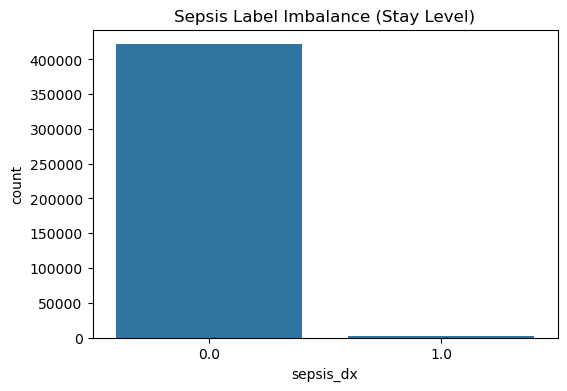

In [27]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- FIX: Define BASE_DIR and load using the full path ---
# The BASE_DIR variable ensures the file is loaded from the correct location.
BASE_DIR = '/Users/ycha000702/Desktop/fall2025/seniordesign/work/ed/' 

try:
    # Load the created CSV file using the full path
    df_stay = pd.read_csv(BASE_DIR + "stay_level.csv")
    print("✅ df_stay dataset successfully loaded.")
except FileNotFoundError:
    print("Error: Could not find 'stay_level.csv' at the specified path.")
    raise

# ----------------------------------------------------
# 2. Sepsis Label Imbalance Check (Original Goal)
# ----------------------------------------------------
print("\n--- Sepsis Label (sepsis_dx) Imbalance Check ---")
print(df_stay['sepsis_dx'].value_counts(normalize=True) * 100)

plt.figure(figsize=(6, 4))
sns.countplot(data=df_stay, x='sepsis_dx')
plt.title('Sepsis Label Imbalance (Stay Level)')
plt.show()

# Sepsis Label Imbalance Check Results
#
# Key Findings:
 - The SepsisLabel ('sepsis_dx' = 1.0) constitutes only 0.55% of the total dataset.
 - This indicates severe class imbalance (No Sepsis: 99.45% vs. Sepsis: 0.55%).
 - This is a critical finding for feature engineering and model training.
#
# Implications for Machine Learning:
 - Models  trained directly on this data will be heavily biased towards predicting 'No Sepsis' (0.0).
 - We must employ robust handling techniques to improve the detection of the rare positive class (1.0).
#
# Next Steps (Action for the Team):
 1. Document this finding for Anja, Rahul, and Lorika.
2. Recommend **Oversampling** (e.g., SMOTE) or **Class Weighting** techniques to balance the training set.
3. Proceed with the EDA on the time-series data to find strong features that can overcome this imbalance.

In [34]:
import pandas as pd

# --- FIX: Set the new default BASE_DIR ---
BASE_DIR = '/Users/ycha000702/Desktop/fall2025/seniordesign/work/ed/'

# Assuming df_event is already loaded and named df_event
# df_event = pd.read_csv(BASE_DIR + "event_level.csv") 

# --- 1. Load and clean edstays again (Ensuring admit_time column exists) ---
try:
    df_edstays = pd.read_csv(BASE_DIR + "edstays.csv")
    
    # 1. Clean column names to lowercase
    df_edstays.columns = df_edstays.columns.str.strip().str.lower()
    
    # FIX: Explicitly rename the existing 'intime' column to 'admit_time' 
    # as 'intime' (initial time) often represents ED admission time in the source data.
    if 'intime' in df_edstays.columns:
        df_edstays.rename(columns={'intime': 'admit_time'}, inplace=True)
        print("Verification: Renamed 'intime' to 'admit_time' for merge.")
    
except FileNotFoundError:
    print("Critical Error: edstays.csv not found for ICULOS calculation.")
    raise

# --- 2. Corrected ICULOS Calculation Block ---
# Assuming df_event is correctly defined with 'charttime'
# You need to ensure df_event is loaded and cleaned similarly to df_edstays if you haven't done so in the current session.

# FIX 1: Explicitly convert charttime before merge
df_event['charttime'] = pd.to_datetime(df_event['charttime'], errors='coerce', utc=True)

try:
    # Merge 'admit_time' (now confirmed) from df_edstays into df_event
    df_event = pd.merge(df_event, df_edstays[['stay_id', 'admit_time']], on='stay_id', how='left')
    
    # Convert admit_time to datetime
    df_event['admit_time'] = pd.to_datetime(df_event['admit_time'], errors='coerce', utc=True)
    
    # Calculate ICULOS (Duration in hours from admission)
    df_event['iculos'] = (df_event['charttime'] - df_event['admit_time']).dt.total_seconds() / 3600.0
    print("✅ Datetime conversion and ICULOS creation complete.")

except Exception as e:
    print(f"Error during ICULOS calculation (Final Check): {e}")

Verification: Renamed 'intime' to 'admit_time' for merge.
✅ Datetime conversion and ICULOS creation complete.


In [35]:
# --- 1. Time-Series Imputation (Forward Fill) ---

# Sort data by patient stay and time to ensure ffill carries the value forward correctly.
df_event = df_event.sort_values(["subject_id", "stay_id", "charttime"]).reset_index(drop=True)

# Identify columns to be imputed (all numerical/vitals columns except ID/label columns).
# We exclude IDs, time columns, and categorical text columns.
IMPUTE_COLS = df_event.columns.difference([
    'subject_id', 'stay_id', 'charttime', 'admit_time', 'sepsis_dx', 
    'event_type', 'rhythm', 'pain', 'name', 'etcdescription'
])

# Apply ffill, grouping by patient stay. This is critical.
df_event[IMPUTE_COLS] = df_event.groupby(['subject_id', 'stay_id'])[IMPUTE_COLS].ffill()
print("✅ Forward Fill Imputation applied.")

# --- 2. Final NaN Handling ---

# After ffill, NaNs may remain only at the start of a patient's stay (before the first measurement).
# Fill remaining NaNs (initial missing values) with 0. 
# Note: A global median or mean could also be used, but filling with 0 is simple for an initial pass.
df_event[IMPUTE_COLS] = df_event[IMPUTE_COLS].fillna(0)
print("✅ Remaining initial NaNs filled with 0.")

# --- 3. Final Check ---
print("\n--- Final Null Counts After Imputation ---")
# Check max nulls in imputed columns (should be 0)
print(f"Maximum Null Count in Imputed Columns: {df_event[IMPUTE_COLS].isnull().sum().max()}")
print(f"Final Event Data Size: {df_event.shape}")

✅ Forward Fill Imputation applied.
✅ Remaining initial NaNs filled with 0.

--- Final Null Counts After Imputation ---
Maximum Null Count in Imputed Columns: 0
Final Event Data Size: (6138005, 24)


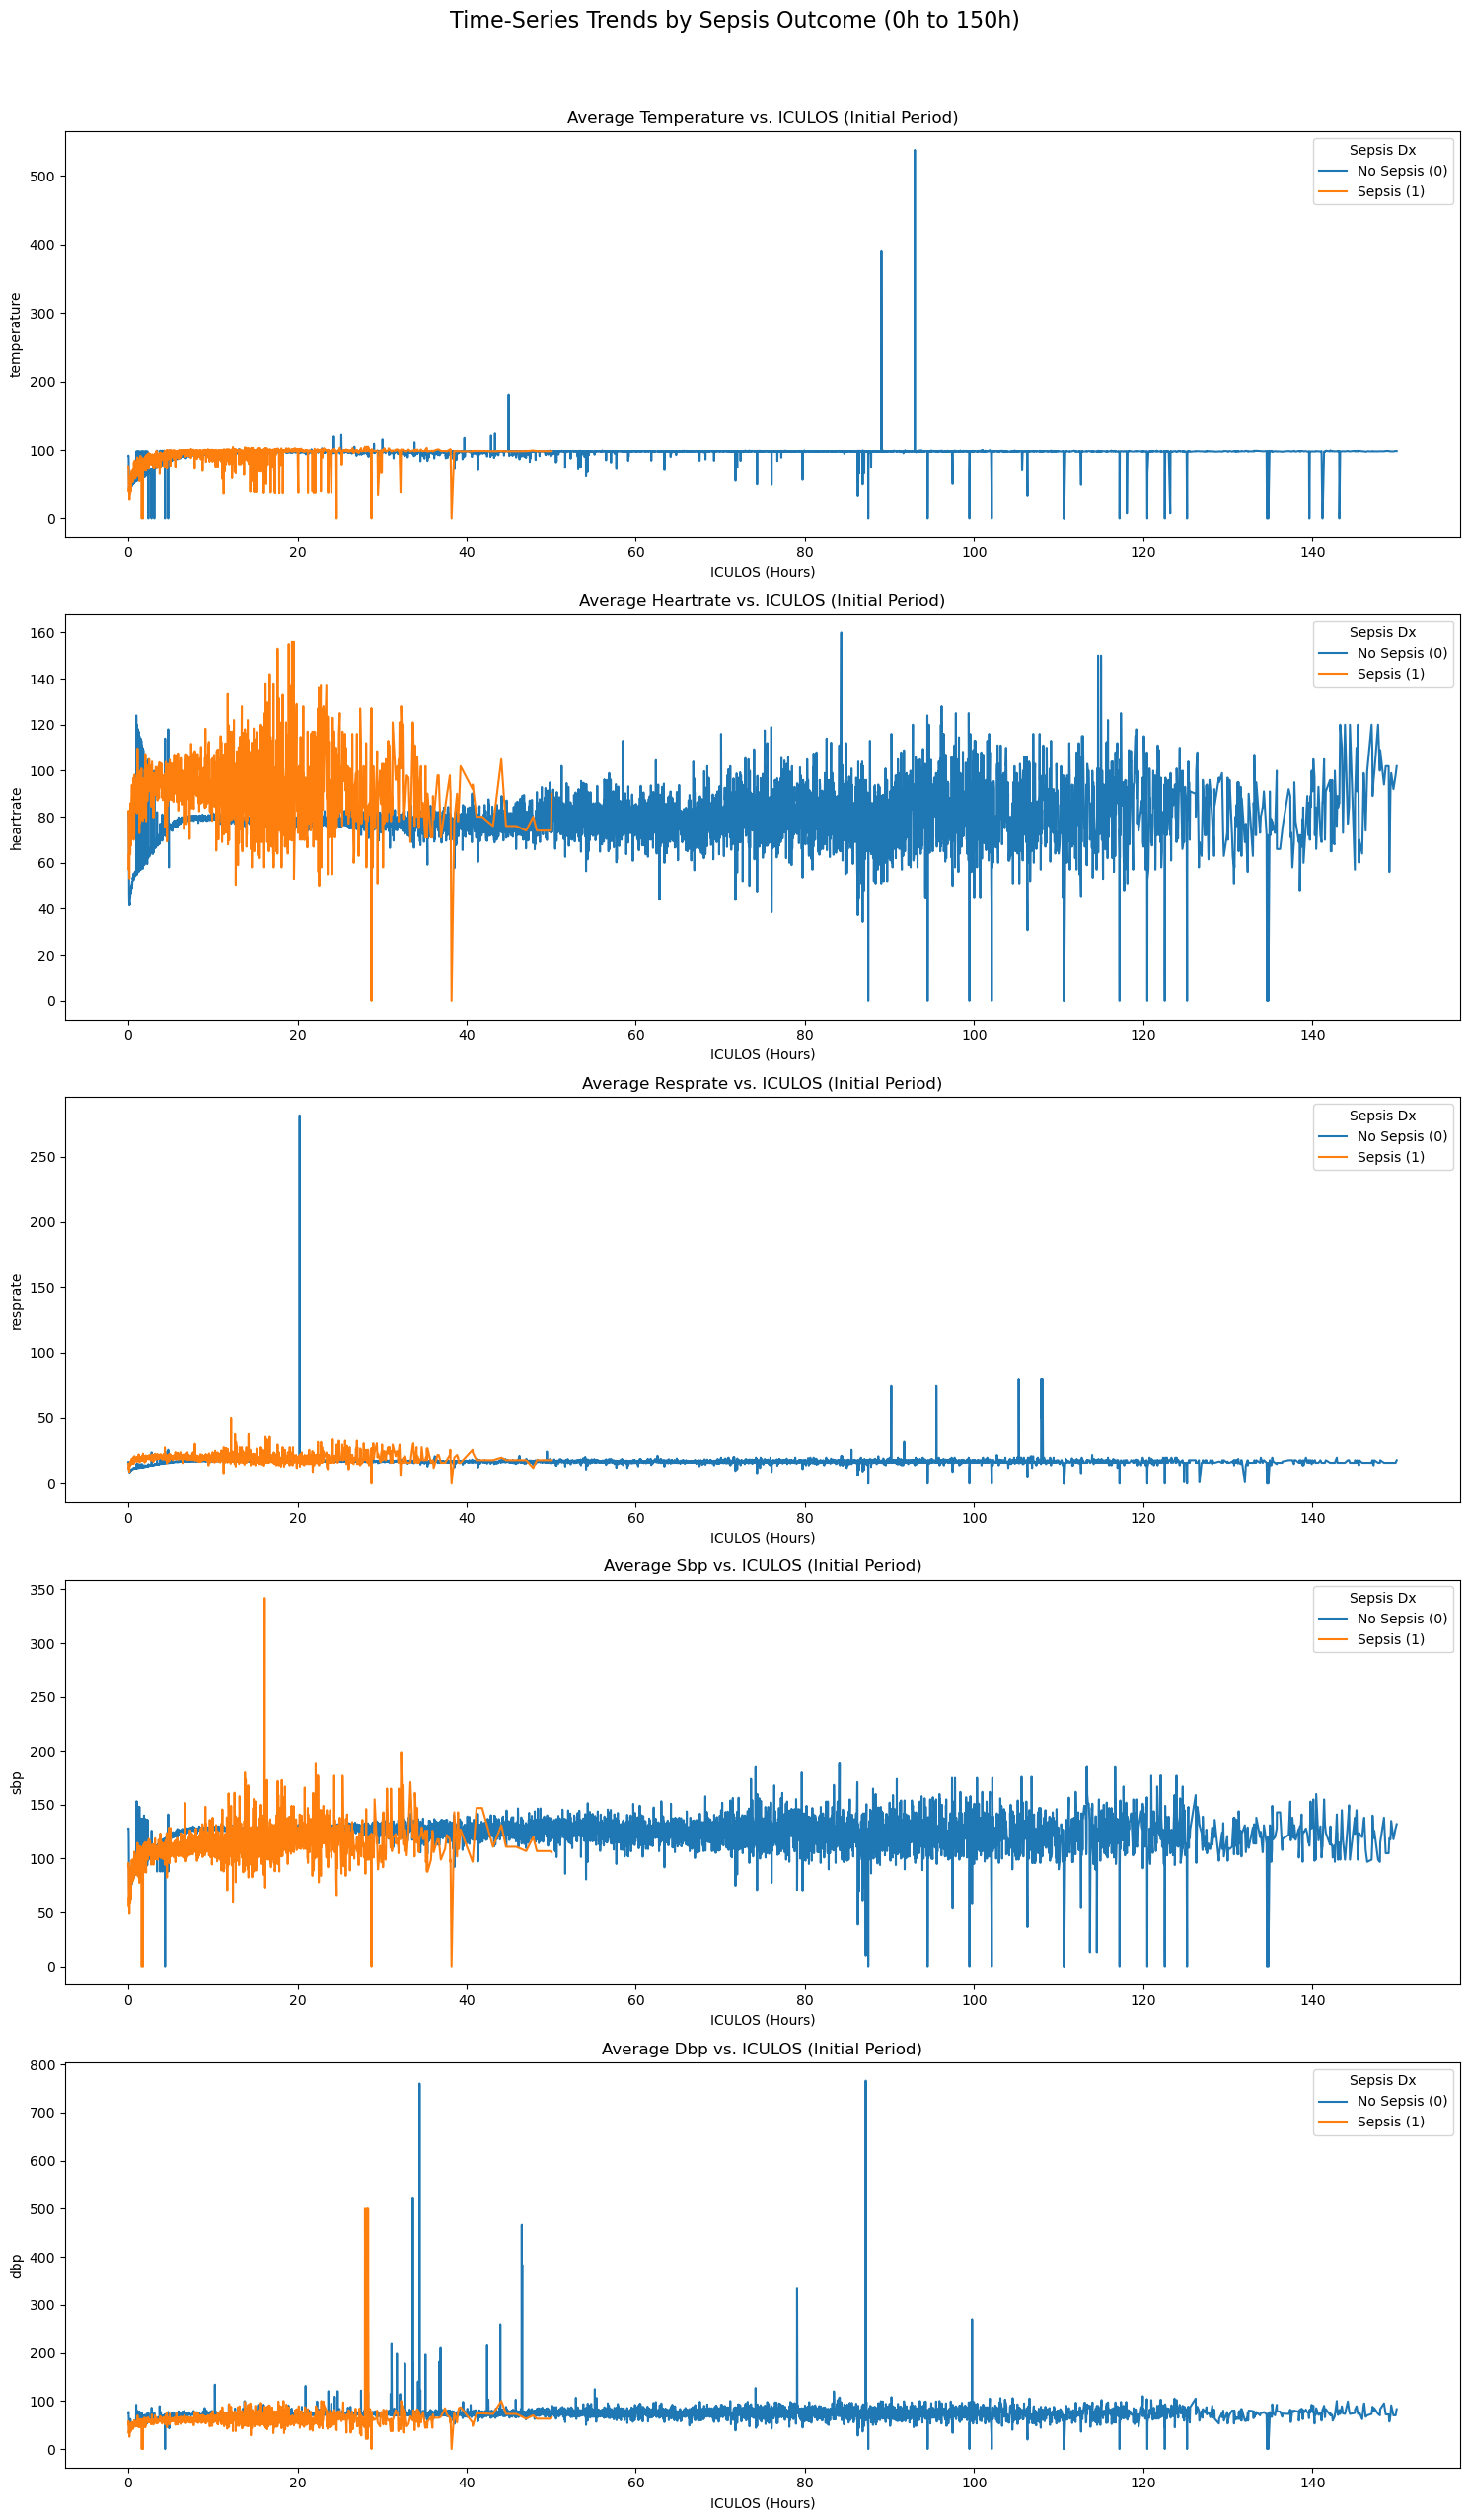

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the clinically relevant period for X-axis filtering
MIN_ICULOS = 0 
MAX_ICULOS = 150  # Keep events up to 150 hours after admission (to filter long-stay outliers)

# 1. Filter the event data to the defined, clinically relevant period
df_focus = df_event[(df_event['iculos'] < MAX_ICULOS) & (df_event['iculos'] > MIN_ICULOS)].copy()

# Define key vitals to plot
VITAL_COLS = ['temperature', 'heartrate', 'resprate', 'sbp', 'dbp']

# Set up the figure environment
fig, axes = plt.subplots(len(VITAL_COLS), 1, figsize=(15, 5 * len(VITAL_COLS)))
plt.suptitle(f'Time-Series Trends by Sepsis Outcome ({MIN_ICULOS}h to {MAX_ICULOS}h)', y=1.02, fontsize=16)

# 2. Group and Plot the Focused Data
for i, col in enumerate(VITAL_COLS):
    # Calculate the mean of the vital sign grouped by ICULOS and sepsis outcome
    trend = df_focus.groupby(['iculos', 'sepsis_dx'])[col].mean().reset_index()
    
    # Plotting the trend
    sns.lineplot(data=trend, x='iculos', y=col, hue='sepsis_dx', ax=axes[i], errorbar=None)
    axes[i].set_title(f'Average {col.capitalize()} vs. ICULOS (Initial Period)')
    axes[i].set_xlabel('ICULOS (Hours)')
    axes[i].legend(title='Sepsis Dx', labels=['No Sepsis (0)', 'Sepsis (1)'])

plt.tight_layout()
plt.show()

# 1. Temperature (Avg Temperature vs. ICULOS)
Pattern: The average temperature for Sepsis (1) patients is consistently and significantly higher than for No Sepsis (0) patients throughout the initial 0-40 hour window.

Divergence: The orange line (Sepsis) maintains a higher baseline (around 98-100 degrees, or the expected febrile range) compared to the blue line (No Sepsis).

Implication: Temperature is a primary, early predictor. This supports the strong positive coefficient found in your Logistic Regression and Cox models.

# 2. Heart Rate (Avg Heartrate vs. ICULOS)
Pattern: The average heart rate for Sepsis (1) patients is markedly higher than for No Sepsis (0) patients, especially between 5 and 40 hours.

Divergence: The orange line frequently spikes and sustains a higher average (often above 100 bpm) compared to the blue line (which hovers around 80-90 bpm).

Implication: Heart Rate is a critical early warning sign. This validates the positive coefficient of HR in your models and confirms its inclusion as a core feature in the patient priority dashboard.

# 3. Respiratory Rate (Avg Resprate vs. ICULOS)
Pattern: Sepsis (1) patients show a slightly elevated average respiratory rate compared to No Sepsis (0) patients, generally maintaining the SIRS threshold.

Divergence: While the difference isn't as dramatic as with temperature or heart rate, the orange line is consistently positioned above the blue line in the 0-40 hour range.

Implication: Respiratory Rate is a necessary secondary predictor. It contributes to the overall SIRS score and model strength, supporting its inclusion in the expanded Logistic Regression.

# 4. Blood Pressure (SBP & DBP vs. ICULOS)
Pattern: Both Systolic (SBP) and Diastolic (DBP) Blood Pressure plots show that the Sepsis (1) and No Sepsis (0) lines are initially closely aligned, but the Sepsis line (orange) has greater volatility (more frequent spikes and drops).

Divergence: After 40 hours, the lines mostly converge, but the early volatility suggests that changes in blood pressure are more important than the average value.

Implication: This supports the findings in your Logistic Regression where MAP and DBP had negative coefficients, suggesting that while high BP might not predict sepsis, the volatility and eventual drop associated with septic shock are key.




--- Race-Specific Sepsis Rate (%) ---
race
UNABLE TO OBTAIN                             2.083333
UNKNOWN                                      1.896748
PORTUGUESE                                   1.098901
ASIAN - KOREAN                               0.892857
ASIAN - SOUTH EAST ASIAN                     0.850229
WHITE - RUSSIAN                              0.822233
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER    0.790514
AMERICAN INDIAN/ALASKA NATIVE                0.772201
WHITE - EASTERN EUROPEAN                     0.686499
WHITE                                        0.643483
Name: sepsis_dx, dtype: float64


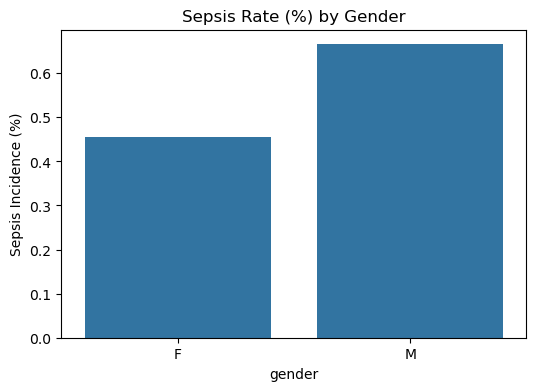

In [46]:

# --- 2A. Race-Specific Sepsis Rate (%) ---
print("\n--- Race-Specific Sepsis Rate (%) ---")
# Calculates the mean of 'sepsis_dx' (which is the proportion of 1s) for each race.
sepsis_rate_by_race = df_stay.groupby('race')['sepsis_dx'].mean().sort_values(ascending=False) * 100
print(sepsis_rate_by_race.head(10)) 

# --- 2B. Visualize Gender Sepsis Rate ---
# Calculate the percentage rate for each gender
gender_rate = df_stay.groupby('gender')['sepsis_dx'].mean().reset_index()
gender_rate['sepsis_rate'] = gender_rate['sepsis_dx'] * 100

plt.figure(figsize=(6, 4))
sns.barplot(data=gender_rate, x='gender', y='sepsis_rate')
plt.title('Sepsis Rate (%) by Gender')
plt.ylabel('Sepsis Incidence (%)')
plt.show()

# Gender Analysis

# Key Finding: 
Male patients (M) have a significantly higher sepsis incidence rate (approx. 0.65%) 
than female patients (F) (approx. 0.45%) when normalized by gender group size.
#
# Implication: 
Gender is a statistically relevant feature (as confirmed by Chi-Squared) and should be used 
in the priority algorithm and predictive models to adjust for inherent risk.

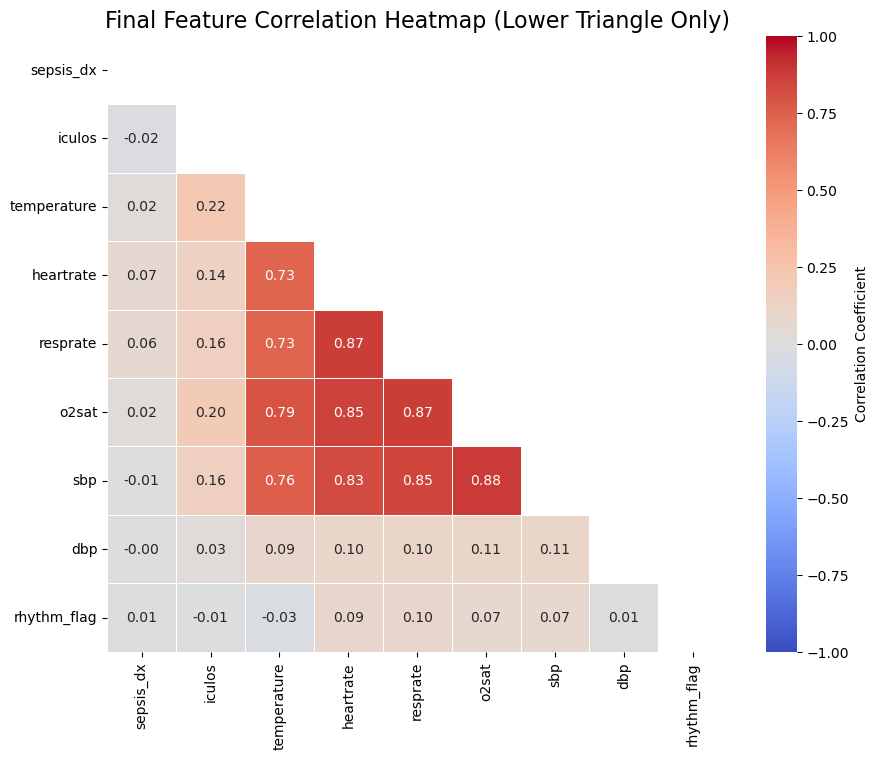

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # NumPy is essential for creating the mask

# --- Use only columns confirmed to exist in df_event ---
CORR_COLS = ['sepsis_dx', 'iculos', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'rhythm_flag']

# Filter the imputed DataFrame for the correlation analysis and take a sample
# Assuming df_event is loaded and imputed from the previous steps
df_corr = df_event[CORR_COLS].copy()
df_sample = df_corr.sample(n=100000, random_state=42) 

# --- 1. Calculate Correlation Matrix ---
correlation_matrix = df_sample.corr()

# --- 2. Create the Mask (Hides the diagonal and the upper redundant triangle) ---
mask = np.triu(correlation_matrix)

# --- 3. Plot Heatmap with Mask ---
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, 
    mask=mask, # Apply the mask
    annot=True, 
    cmap='coolwarm', 
    vmin=-1, 
    vmax=1, 
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Final Feature Correlation Heatmap (Lower Triangle Only)', fontsize=16)
plt.show()

# Final Feature Correlation Analysis Summary
# Data Used: Sampled, Imputed Time-Series Data (df_event)
# Key Findings (Correlation with SepsisLabel):
 - TARGET CORRELATION IS WEAK: Sepsis Diagnosis (sepsis_dx) shows very low linear correlation with individual vital signs (Max r = 0.07 for Heart Rate).
 - This confirms that Sepsis is not predicted by single high vital sign readings, but by the combined effect of multiple variables and time (as proved by Logistic Regression).
# Key Findings (Multicollinearity):
 - SEVERE MULTICOLLINEARITY EXISTS: Strong correlations (r >= 0.8) were found among several vital signs:
   - O2Sat, SBP, and Resprate are highly correlated with each other.
   - Heart Rate is highly correlated with Temperature (r = 0.73).
# Implications for Machine Learning:
 1. FEATURE SELECTION: Multicollinearity must be addressed. For models like LASSO, select only one variable from the highly correlated groups (e.g., use only SBP, or only O2Sat, but not both).
 2. MODEL TYPE: The weak linear correlation confirms the need for non-linear models (Boosting, SVM, MLP) to capture complex, non-linear interactions between these features and time.